# Smoke Signals in Pop Culture: Analyzing Smoking References in Music and Its Social Impact via NLP

## Overview
Over the last seven decades, Australia has experienced a dramatic decline in smoking rates. From around 50% of the population in 1945, smoking has dropped to roughly 10% as of last year. This remarkable shift coincides with growing awareness of health risks, changing public perceptions, and increasingly strict regulations targeting both smokers and tobacco companies.

The Australian government has implemented numerous measures: comprehensive advertising bans across all media, a cumulative 320% increase in tobacco excise through nine separate tax hikes, plain packaging laws, and graphic health warnings on cigarette packs. These efforts have certainly made an impact, but certain areas remain difficult to regulate - particularly entertainment media like films, TV, music, books, and video games.

While product placement for specific cigarette brands is illegal in Australia, the depiction of smoking itself remains unregulated in these media. Studies have shown that exposure to smoking in media not only correlates with smoking uptake but can actively cause young people to start smoking. This is where our analysis comes in.

## Project Goal
This project aims to analyse smoking references in popular music lyrics and explore their relationship with smoking prevalence in Australia over time. We'll use web scraping, natural language processing, and machine learning techniques to see if there's a meaningful connection between smoking references in songs and real-world smoking rates.

## Our Approach
We're tackling this in four main stages:

1. Data Collection: Gathering lists of popular songs from three sources - the Kent Music Report (1955-1987), ARIA charts (1988-2023), and Triple J Hottest 100 (1993-2023)
2. Lyrics Extraction: Using web scraping to collect lyrics for these songs from Genius.com
3. Text Analysis: Processing the lyrics to identify smoking references through keyword matching, TF-IDF analysis, and other NLP techniques
4. Predictive Modeling: Building machine learning models to explore relationships between music references and smoking prevalence

Let's dive into each stage of the process!

In [1]:
import requests
from io import StringIO
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import re
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Data Collection
## Smoking Prevalence Data
Our first dataset comes from surveys conducted by the Australian Institute of Health and Welfare and the Cancer Council Victoria.

In [2]:
smoking_prev = pd.read_csv('data/prevalence_of_current_smokers.csv') # import data
print(smoking_prev)

    Year  Males  Females
0   1945   72.0     26.0
1   1964   58.0     28.0
2   1969   45.0     28.0
3   1974   45.0     30.0
4   1976   43.0     33.0
5   1980   41.0     30.0
6   1983   40.0     29.0
7   1986   34.0     28.0
8   1989   30.0     27.0
9   1992   29.0     24.0
10  1995   28.0     24.0
11  1998   27.0     25.0
12  2001   26.5     21.1
13  2004   23.7     19.4
14  2007   22.4     18.4
15  2010   20.8     17.0
16  2013   18.9     13.9
17  2016   18.0     13.4
18  2019   16.6     12.8
19  2022   12.2     10.0


Since the surveys were only conducted every few years (every 5 years between 1945-1976 and every 3 years between 1980-2022), we used cubic interpolation to estimate values for all years. This gives us a smooth curve that reasonably approximates the actual trend while providing data points for every year in our analysis period.

In [3]:
data = pd.DataFrame({'Year':range(1945,2023)}) # define every year in period

def interpolate_years(series):
    x = smoking_prev['Year']
    y = series
    f = PchipInterpolator(x, y) # cubic interpolation of existing values across all years
    return f(data['Year']) # return function across all years

data['Males'] = interpolate_years(smoking_prev['Males']).round(1) # interpolate 'Males' data
data['Females'] = interpolate_years(smoking_prev['Females']).round(1) # interpolate 'Females' data
data['All'] = ((data['Males'] + data['Females']) / 2).round(1) # average prevalance for total value

print(data.head(20))

    Year  Males  Females   All
0   1945   72.0     26.0  49.0
1   1946   72.0     26.2  49.1
2   1947   71.8     26.4  49.1
3   1948   71.6     26.5  49.0
4   1949   71.3     26.7  49.0
5   1950   70.9     26.9  48.9
6   1951   70.4     27.0  48.7
7   1952   69.8     27.1  48.4
8   1953   69.2     27.3  48.2
9   1954   68.4     27.4  47.9
10  1955   67.7     27.5  47.6
11  1956   66.8     27.6  47.2
12  1957   65.9     27.7  46.8
13  1958   64.9     27.8  46.4
14  1959   63.9     27.8  45.8
15  1960   62.8     27.9  45.3
16  1961   61.7     27.9  44.8
17  1962   60.5     28.0  44.2
18  1963   59.3     28.0  43.6
19  1964   58.0     28.0  43.0


As seen in the code and resulting visualisations, we've created a comprehensive dataset showing smoking rates for males, females, and the overall population across our entire study period. The interpolation provides a good fit to the actual survey data points.

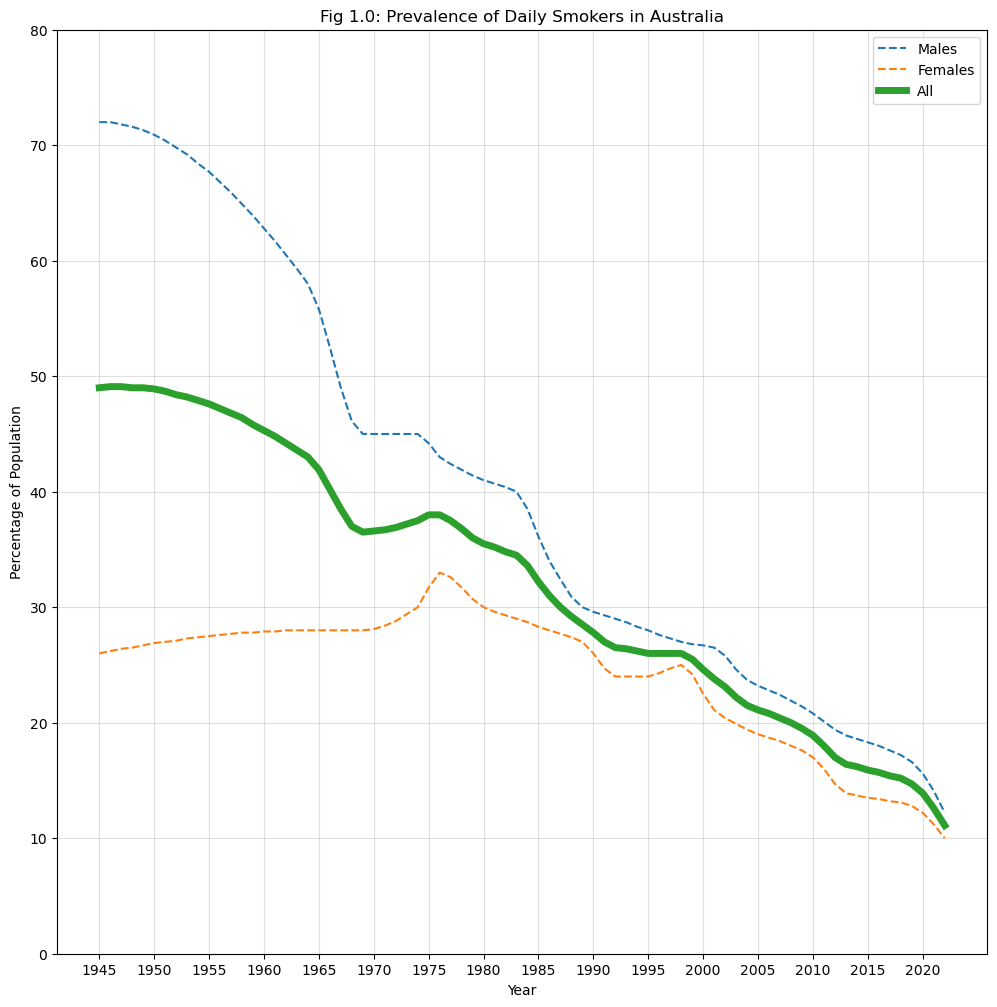

In [4]:
plt.figure(figsize=(12, 12))

sns.lineplot(data,y='Males',x='Year',label='Males',linestyle='--')
sns.lineplot(data,y='Females',x='Year', label='Females',linestyle='--')
sns.lineplot(data,y='All',x='Year', label='All',linewidth=5)

plt.xticks(range(1945, 2023, 5))
plt.ylim(0,80)
plt.grid(True,alpha=0.4)

plt.title('Fig 1.0: Prevalence of Daily Smokers in Australia')
plt.xlabel('Year')
plt.ylabel('Percentage of Population')

plt.legend()

plt.show()

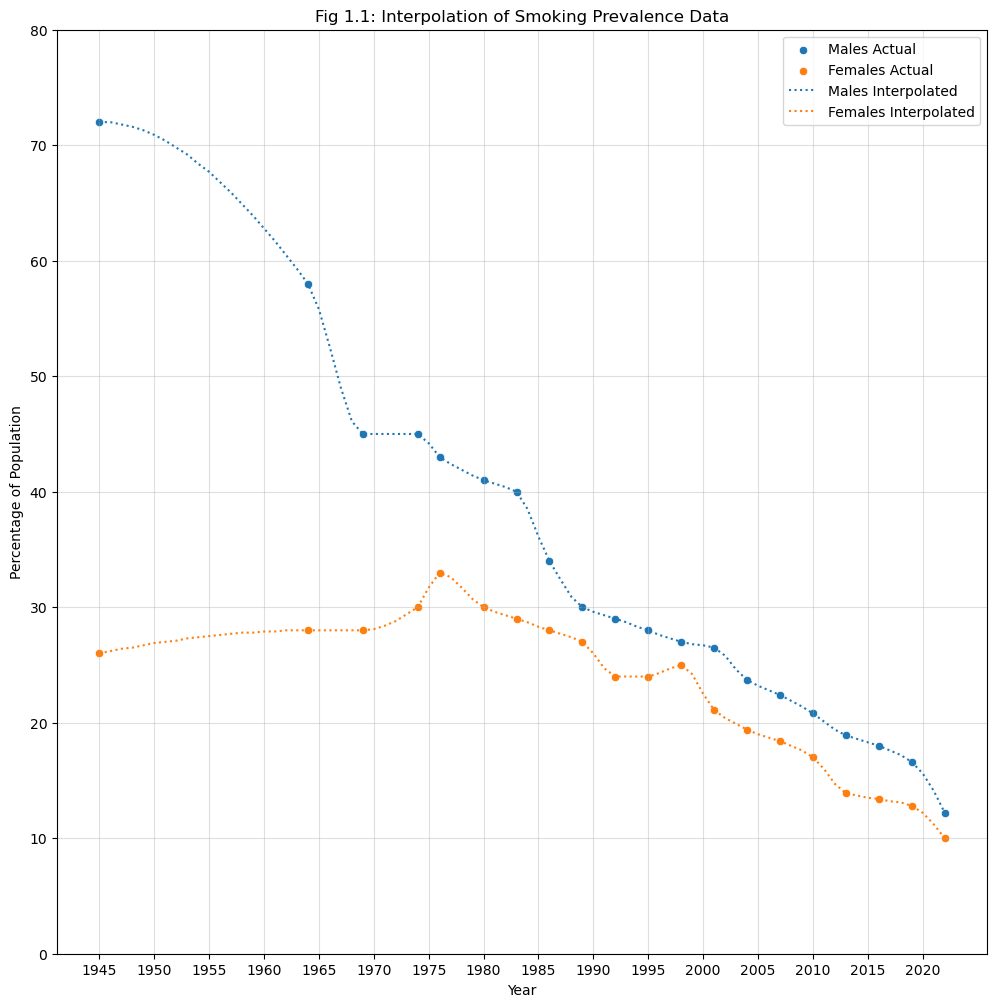

In [5]:
plt.figure(figsize=(12, 12))

#sns.lineplot(smoking_prev,y='Males',x='Year', linestyle = "-")
sns.scatterplot(smoking_prev,y='Males',x='Year',label='Males Actual')
#sns.lineplot(smoking_prev,y='Females',x='Year')
sns.scatterplot(smoking_prev,y='Females',x='Year', label='Females Actual')
sns.lineplot(data,y='Males',x='Year',linestyle=':',label='Males Interpolated')
sns.lineplot(data,y='Females',x='Year',linestyle=':',label='Females Interpolated')

plt.xticks(range(1945, 2023, 5))
plt.ylim(0,80)
plt.grid(True,alpha=0.4)

plt.title('Fig 1.1: Interpolation of Smoking Prevalence Data')
plt.xlabel('Year')
plt.ylabel('Percentage of Population')

plt.legend()

plt.show()

In [6]:
data = data[10:] # slice years of interest
data.reset_index(drop=True,inplace=True) # reset the index post slice


data.to_csv("data/data.csv",index=False) # save a backup of the data
display(data.head(10))

,Year,Males,Females,All
0,1955,67.7,27.5,47.6
1,1956,66.8,27.6,47.2
2,1957,65.9,27.7,46.8
3,1958,64.9,27.8,46.4
4,1959,63.9,27.8,45.8
5,1960,62.8,27.9,45.3
6,1961,61.7,27.9,44.8
7,1962,60.5,28.0,44.2
8,1963,59.3,28.0,43.6
9,1964,58.0,28.0,43.0


## Popular Music Data
For our analysis to be meaningful, we need to understand what songs were popular in Australia during each year of our study. We've created three custom web scrapers to collect this information:

### Kent Music Report (1955 - 1988)
We scraped this data from Wikipedia, which provides lists of the top 25 singles for each year.

In [19]:

kent = pd.DataFrame(columns=['Title','Artist','year'])

for year in range(1955,1988,1):
    page = "https://en.wikipedia.org/wiki/List_of_top_25_singles_for_" + str(year) + "_in_Australia"
    print(page)
    page = requests.get(page)
    soup = BeautifulSoup(page.text,'lxml')

    song_table = soup.find('table',{'class':'wikitable sortable'})
    df = pd.read_html(StringIO(str(song_table)),index_col='#')[0] # read the table into a dataframe
    df['year'] = year # record the year
    df['source'] = "kent"
    df.index = df.index.astype(int) # convert index to int
    df.Title = df.Title.str[1:-1] # Remove quotations

    kent = pd.concat([kent,df[['Title','Artist','year','source']]],axis=0)

kent.to_csv("data/kent.csv",index=False) # save a backup of the data
display(kent)

https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1955_in_Australia


C:\Users\Steve\AppData\Local\Temp\ipykernel_12016\1537238534.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  kent = pd.concat([kent,df[['Title','Artist','year','source']]],axis=0)


https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1956_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1957_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1958_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1959_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1960_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1961_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1962_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1963_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1964_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1965_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1966_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1967_in_Australia
https://en.wikipedia.org/wiki/List_of_top_25_singles_for_1968_in_Australia
https://en.wikipedia.org/

,Title,Artist,year,source
1,Hold My Hand,Don Cornell; Nat King Cole,1955,kent
2,Rock Around the Clock,Bill Haley and His Comets,1955,kent
3,Melody of Love,The Four Aces; Billy Vaughn,1955,kent
4,Unchained Melody,Al Hibbler; Les Baxter,1955,kent
5,I Need You Now,Eddie Fisher,1955,kent
...,...,...,...,...
21,Beds Are Burning,Midnight Oil,1987,kent
22,Bad,Michael Jackson,1987,kent
23,Good Times,INXS With Jimmy Barnes,1987,kent
24,Star Trekkin',The Firm,1987,kent


### Aria (1988 - 2024)
We collected this directly from the ARIA website, focusing on their annual top singles.

In [20]:
aria = pd.DataFrame(columns=['Title','Artist','year'])

for year in range(1988,2025,1):
    page = "https://www.aria.com.au/charts/" + str(year) + "/singles-chart"
    print(page)
    page = requests.get(page)
    soup = BeautifulSoup(page.text,'lxml')

    titles = soup.select('ul li a.c-chart-item__title')
    artists = soup.select('ul li a.c-chart-item__artist')

    titles = [title.get_text() for title in titles]
    artists = [artist.get_text() for artist in artists]

    df = pd.DataFrame({'Title': titles,'Artist': artists,'year': year,'source': "aria"})
    

    aria = pd.concat([aria,df],axis=0)

aria.to_csv("data/aria.csv",index=False) # save a backup of the data
display(aria)

https://www.aria.com.au/charts/1988/singles-chart
https://www.aria.com.au/charts/1989/singles-chart
https://www.aria.com.au/charts/1990/singles-chart
https://www.aria.com.au/charts/1991/singles-chart
https://www.aria.com.au/charts/1992/singles-chart
https://www.aria.com.au/charts/1993/singles-chart
https://www.aria.com.au/charts/1994/singles-chart
https://www.aria.com.au/charts/1995/singles-chart
https://www.aria.com.au/charts/1996/singles-chart
https://www.aria.com.au/charts/1997/singles-chart
https://www.aria.com.au/charts/1998/singles-chart
https://www.aria.com.au/charts/1999/singles-chart
https://www.aria.com.au/charts/2000/singles-chart
https://www.aria.com.au/charts/2001/singles-chart
https://www.aria.com.au/charts/2002/singles-chart
https://www.aria.com.au/charts/2003/singles-chart
https://www.aria.com.au/charts/2004/singles-chart
https://www.aria.com.au/charts/2005/singles-chart
https://www.aria.com.au/charts/2006/singles-chart
https://www.aria.com.au/charts/2007/singles-chart


,Title,Artist,year,source
0,(I've Had) The Time Of My Life,Bill Medley & Jennifer Warnes,1988,aria
1,Simply Irresistible,Robert Palmer,1988,aria
2,The Flame,Cheap Trick,1988,aria
3,"Get Outta My Dreams, Get Into My Car",Billy Ocean,1988,aria
4,I Should Be So Lucky,Kylie Minogue,1988,aria
...,...,...,...,...
95,Stay,The Kid Laroi & Justin Bieber,2024,aria
96,Nonsense,Sabrina Carpenter,2024,aria
97,Carnival,"Kanye West, Ty Dolla $ign",2024,aria
98,Hot To Go!,Chappell Roan,2024,aria


### Hottest 100 (1993 - 2023)
This data was scraped from Wikipedia as well.

In [21]:
h100 = pd.DataFrame(columns=['Title','Artist','year'])

for year in range(1993,2024,1):
    page = "https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_" + str(year)
    print(page)
    page = requests.get(page)
    soup = BeautifulSoup(page.text,'lxml')

    song_table = soup.find('table',{'class':'wikitable sortable'})
    df = pd.read_html(StringIO(str(song_table)),index_col='#')[0] # read the table into a dataframe
    df['year'] = year # record the year
    df['source'] = "h100"
    df.index = df.index.astype(int) # convert index to int
    df = df.rename(columns={df.columns[0]: 'Title',df.columns[1]: 'Artist'})

    h100 = pd.concat([h100,df[['Title','Artist','year','source']]],axis=0)

h100.to_csv("data/h100.csv",index=False) # save a backup of the data
display(h100)

https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_1993


C:\Users\Steve\AppData\Local\Temp\ipykernel_12016\3615436477.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  h100 = pd.concat([h100,df[['Title','Artist','year','source']]],axis=0)


https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_1994
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_1995
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_1996
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_1997
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_1998
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_1999
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2000
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2001
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2002
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2003
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2004
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2005
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2006
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2007
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2008
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2009
https://en.wikipedia.org/wiki/Triple_J_Hottest_100,_2010
https://en.wikipedia.org/wiki/T

,Title,Artist,year,source
1,Asshole,Denis Leary,1993,h100
2,Creep,Radiohead,1993,h100
3,Linger,The Cranberries,1993,h100
4,No Rain,Blind Melon,1993,h100
5,Cannonball,The Breeders,1993,h100
...,...,...,...,...
96,Boys Light Up,Chillinit,2023,h100
97,Stay Blessed,Genesis Owusu,2023,h100
98,Cool About It,Boygenius,2023,h100
99,I Miss You (Like a Version),Slowly Slowly,2023,h100


## Combining and Tidying Popular Song lists 
Each scraper works similarly - it iterates through years, constructs the appropriate URL, extracts the song information, and stores it in a dataframe. After running all three scrapers, we merged the results into a single comprehensive dataset of popular songs spanning almost seven decades.

In [22]:
song_list = pd.concat([kent,aria,h100]) # combine song list dataframes
#song_list['Rank'] = song_list.index # save rank data

song_list['Artist'] = song_list['Artist'].str.split(';').str[0] # Keep only first artist in artist column
song_list['Artist'] = song_list['Artist'].str.split(' &').str[0] # Keep only first artist in artist column
print(song_list)

song_list.to_csv("data/song_list.csv",index=False) # save a backup of the data

                           Title                     Artist  year source
1                   Hold My Hand                Don Cornell  1955   kent
2          Rock Around the Clock  Bill Haley and His Comets  1955   kent
3                 Melody of Love              The Four Aces  1955   kent
4               Unchained Melody                 Al Hibbler  1955   kent
5                 I Need You Now               Eddie Fisher  1955   kent
..                           ...                        ...   ...    ...
96                 Boys Light Up                  Chillinit  2023   h100
97                  Stay Blessed              Genesis Owusu  2023   h100
98                 Cool About It                  Boygenius  2023   h100
99   I Miss You (Like a Version)              Slowly Slowly  2023   h100
100             Lost the Breakup              Maisie Peters  2023   h100

[7175 rows x 4 columns]


In [23]:
# ensure formatting for songs and artists are as similar as possible for duplicate search
def clean_artist(artist):
    artist = artist.replace("/"," ")
    artist = re.sub(r'[^a-zA-Z\s]', '', artist).lower() # remove non alphabetic characters
    artist = artist.split("feat")[0]
    artist = artist.split("featuring")[0].strip()
    return artist

def clean_title(title):
    # clean track
    title = title.split("/")[0]
    title = re.sub(r'[^a-zA-Z\s]', '', title).lower().strip() # remove non alphabetic characters
    return title

In [24]:
song_list['clean_artist'] = song_list['Artist'].apply(clean_artist)
song_list['clean_title'] = song_list['Title'].apply(clean_title)

In [25]:
song_list.drop_duplicates(inplace=True, subset=['clean_title','clean_artist']) # remove any songs that are duplicated
song_list.index = range(0,len(song_list)) # recreate index

Our final song list contains 6,250 songs from 3,058 unique artists over 69 years. The histogram showing songs per year reveals how our data is distributed over time, with more songs available in later years.

In [26]:
print(f"Number of Songs: {len(song_list)}")
print(f"Number of Artists: {len(song_list.Artist.unique())}")
print(f"Number of Years: {len(song_list.year.unique())}")

Number of Songs: 6378
Number of Artists: 3101
Number of Years: 70


<Axes: title={'center': 'Fig 1.2: Song count by year'}, xlabel='count', ylabel='year'>

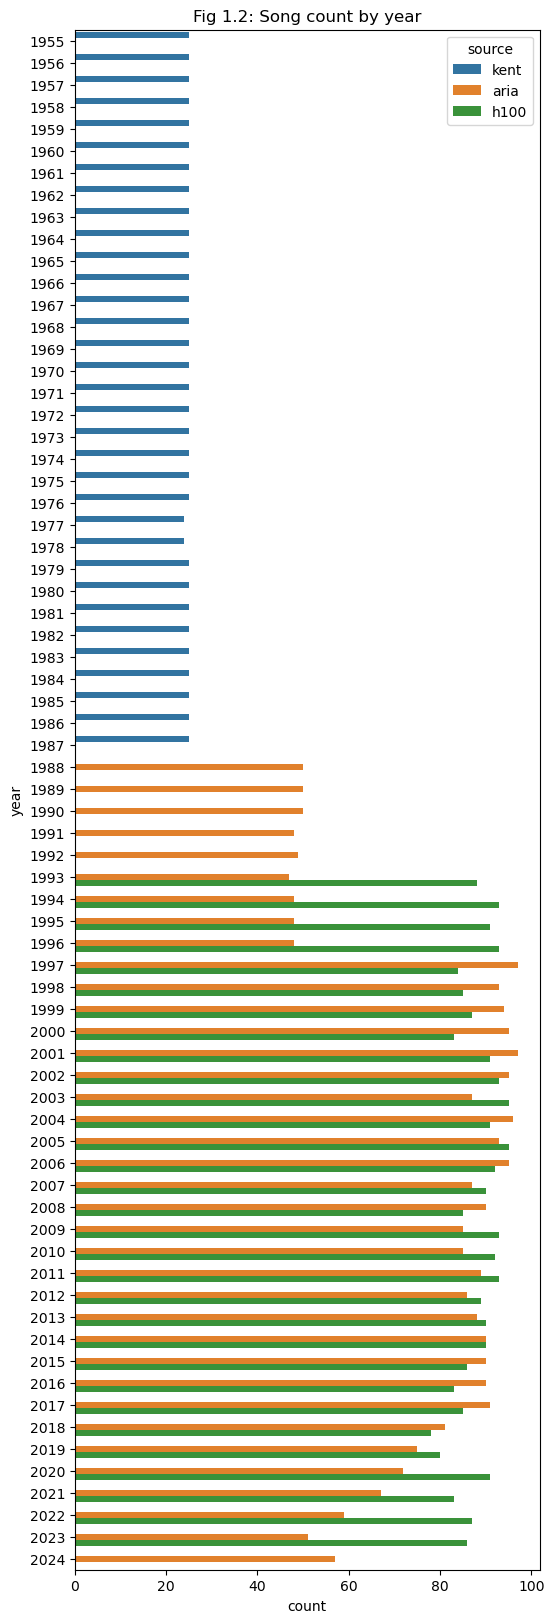

In [27]:
plt.figure(figsize=(6, 20))
plt.title('Fig 1.2: Song count by year')
sns.countplot(song_list,y='year',hue='source',dodge=True)


## Gathering Lyrics
With our list of popular songs in hand, the next challenge was obtaining the lyrics. For this, we built a more sophisticated web scraper to extract lyrics from Genius.com. This scraper uses multiple approaches:

- First attempt: Direct URL construction using the artist and title
- Second attempt: API search when direct URLs fail
- Third attempt: Further cleaning of artist/title data and another API search

Using this multi-tiered approach, we were able to successfully retrieve lyrics for the vast majority of our songs, though 382 songs (about 6%) remained without lyrics. This is a reasonable outcome given the challenges of matching song titles and artists across different formats and time periods.

In [7]:
def clean_lyrics(lyric_blocks):
    lyrics = ""
    for i in lyric_blocks:
        lyric = i.get_text(separator=". ")
        lyrics = lyrics + lyric
    return lyrics

# function to scrape page and isolate lyrics object
def scrape_lyrics(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'lxml')
    lyric_blocks = soup.find_all('div', {'class': 'Lyrics__Container-sc-1ynbvzw-1 kUgSbL'})
    
    lyrics = clean_lyrics(lyric_blocks)

    return lyrics


# function to search genius API and return 'url' object
def search_genius_api(artist, title):
    access_token = "O4i44P7pOWnzGzOrH3BP9pbWNIRtNSbM_9ZxDv16zN8jtQOwfPNsMSTPOcdRH27P" # genius api token

    artist = artist.replace(" ","%20")
    title = title.replace(" ","%20")

    genius_api_url = f"http://api.genius.com/search?q={title}%20{artist}&access_token={access_token}"

    print(f"Trying {genius_api_url}")

    page = requests.get(genius_api_url).json()
        
    try:
        url = page["response"]["hits"][0]["result"]["url"]
        return url
    except:
        print("Search returned none.")
        return None


# function to attempt to locate song page on genius via three methods
def gather_lyrics(artist, title, first_artist): 
    # clean artist
    artist = artist.replace(" ", "-").lower()
    #print(f" Artist: {artist}")

    # clean title
    title = title.replace(" ", "-").lower()
    print(f" Title: {title}")
    
    
    try:
        # quick method (url construction)
        search_string = artist + "-" + title
        url = "https://genius.com/" + search_string + "-lyrics"
        print(f"Trying {url}")

        lyrics = scrape_lyrics(url)
        
        if lyrics:
            return lyrics
        else:
            print(f"Failed.")
        # end of quick method


        # api method 1
        #print("Trying API Method 1")
        url = search_genius_api(artist, title)

        if url:
            lyrics = scrape_lyrics(url)
            return lyrics
        else:
            # api method 2

            # more artist cleaning
            #print("Trying API Method 2")
            artist = first_artist.split(" and.")[0]
            artist = artist.replace("the", "")
            print(f" Artist as: {artist}")

            # more title cleaning
            title = title.replace("the", "")
            print(f" Title as: {title}")

            # attempt api search with new artist/title
            url = search_genius_api(artist, title)

            if url:
                lyrics = scrape_lyrics(url)
                return lyrics
            else:
                print("No lyrics found")
                return ""
            
    except Exception as e:
        print(f"Error occurred for {artist} - {title}: {str(e)}")
        return ""

In [10]:
test_lyrics = gather_lyrics("The Beatles","roll over beethoven   hold me tight","the beatles") # testing the functions
print(test_lyrics)

 Title: roll-over-beethoven---hold-me-tight
Trying https://genius.com/the-beatles-roll-over-beethoven---hold-me-tight-lyrics
Failed.
Trying http://api.genius.com/search?q=roll-over-beethoven---hold-me-tight%20the-beatles&access_token=O4i44P7pOWnzGzOrH3BP9pbWNIRtNSbM_9ZxDv16zN8jtQOwfPNsMSTPOcdRH27P
Search returned none.
 Track as: roll-over-beethoven---hold-me-tight
Trying http://api.genius.com/search?q=roll-over-beethoven---hold-me-tight%20%20beatles&access_token=O4i44P7pOWnzGzOrH3BP9pbWNIRtNSbM_9ZxDv16zN8jtQOwfPNsMSTPOcdRH27P
Search returned none.
No lyrics found



In [8]:
# function to iterate the song page search function over a DF column
def populate_lyrics_column(row):
    print(row.name)
    artist = row['clean_artist']
    first_artist = clean_artist(row['Artist'].split("/")[0])
    title = row["clean_title"]
    print(f"Scraping {artist} - {title}")

    lyrics = gather_lyrics(artist, title, first_artist)
    print(lyrics[0:60])
    return(lyrics)

In [ ]:
# run function over lyrics column
song_list['lyrics'] = song_list.apply(populate_lyrics_column, axis=1) # apply the function on the song_list dataset

In [23]:
# identify missing tracks
missing_titles = song_list.index[song_list.lyrics == ""]
len(missing_titles)

382

In [24]:
print(song_list)

                            Title                     Artist  year source  \
0                    Hold My Hand                Don Cornell  1955   kent   
1           Rock Around the Clock  Bill Haley and His Comets  1955   kent   
2                  Melody of Love              The Four Aces  1955   kent   
3                Unchained Melody                 Al Hibbler  1955   kent   
4                  I Need You Now               Eddie Fisher  1955   kent   
...                           ...                        ...   ...    ...   
6245                Boys Light Up                  Chillinit  2023   h100   
6246                 Stay Blessed              Genesis Owusu  2023   h100   
6247                Cool About It                  Boygenius  2023   h100   
6248  I Miss You (Like a Version)              Slowly Slowly  2023   h100   
6249             Lost the Breakup              Maisie Peters  2023   h100   

                   clean_artist                clean_title  \
0            

## Creating the Corpus and Text Analysis

### Cleaning and Preprocessing
Text analysis requires careful preprocessing. We:

- Removed non-alphabetic characters
- Converted all text to lowercase
- Eliminated excess whitespace
- Removed common English stopwords
- Added custom stopwords relevant to song structure (like "chorus" and "verse")

In [35]:
# clean the text
def clean_text(text):
    text = (re.sub(r'[^a-zA-Z\s]', '', text)) # remove everything except alphabets
    text = ' '.join(text.split()) # remove whitespaces 
    text = text.lower() # convert text to lowercase 

    return text

song_list['cleaned_lyrics'] = (song_list['clean_title'] + " " + song_list['lyrics']).astype(str)
song_list['cleaned_lyrics'] = song_list['cleaned_lyrics'].apply(clean_text)

In [36]:
# download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# add custom stop words
stop_words.update(['chorus','verse','prechorus','instrumental'])

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

song_list['cleaned_lyrics'] = song_list['cleaned_lyrics'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Corpus EDA

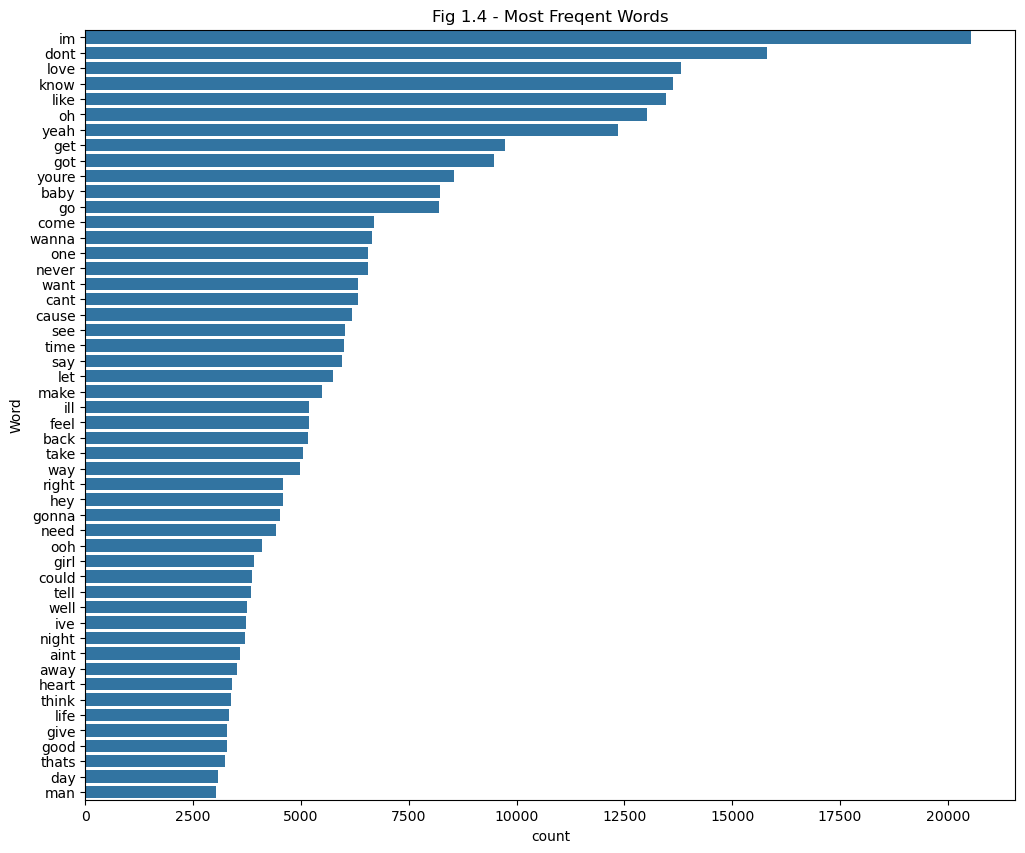

In [77]:
def freq_words(x, terms = 30,title=""): 
  all_words = ' '.join([text.lower() for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,10)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.title(title)
  plt.show()
  
# print 100 most frequent words 
freq_words(song_list['cleaned_lyrics'], 50,"Fig 1.4 - Most Freqent Words")

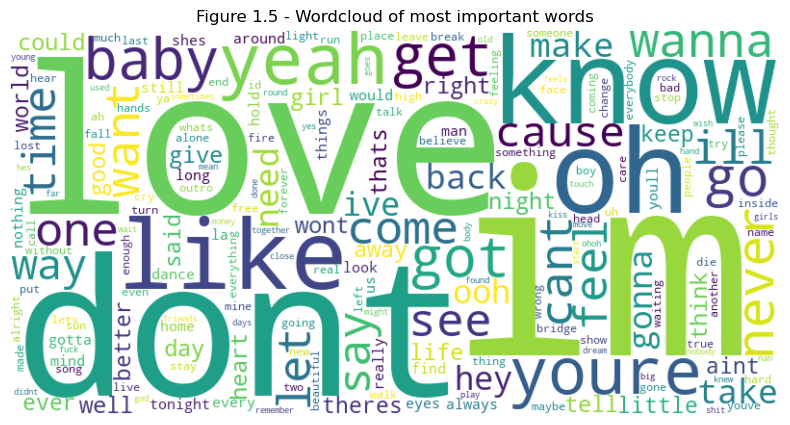

In [78]:
# finding the most 'important' words in the corpus via TF IDF
tfidf = TfidfVectorizer() # the vectoriser is created
tfidf_matrix = tfidf.fit_transform(song_list['cleaned_lyrics'])

feature_names = tfidf.get_feature_names_out() # get feature names
word_scores = np.array(tfidf_matrix.sum(axis=0)).flatten() # get scores
word_score_df = pd.DataFrame({'word': feature_names, 'score': word_scores}) # create dataframe for results
word_score_dict = dict(zip(word_score_df['word'], word_score_df['score']))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_score_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Figure 1.5 - Wordcloud of most important words')
plt.show()

## Identifying Smoking References
To track smoking references in songs, we created a lexicon of smoking-related terms like "cigarette," "smoke," "tobacco," etc.

## Defining Smoking Terminology

In [448]:
smoking_words = ['cigarette',
                 'cigarettes',
                 'tobacco',
                 'nicotine',
                 'cigar',
                 'lighter',
                 'ash',
                 'smoke',
                 'smoker',
                 'smokin',
                 'smoking',
                 'puff',
                 'inhale',
                 'butt',
                 'smokes',
                 'cigs',
                 'cig',
                 'drag',
                 'camel',
                 'chesterfield',
                 'marlboro',             
                 'winfield']

We expanded this initial list using word embeddings from the pre-built Word2Vec model to capture related terminology.

In [ ]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [449]:
def find_similar_words(word, n=10):
    try:
        similar_words = w2v.most_similar(word, topn=n)
        return [(word, round(score, 4)) for word, score in similar_words]
    except KeyError:
        return []
    
# Find similar words for each smoking-related word
expanded_smoking_words = set()
for word in smoking_words:
    similar = find_similar_words(word, w2v)
    print(f"Words similar to '{word}':")
    for similar_word, score in similar:
        print(f"  {similar_word}: {score}")
        expanded_smoking_words.add(similar_word)

Words similar to 'cigarette':
  cigarettes: 0.8289
  Cigarette: 0.7099
  tobacco: 0.6918
  cig: 0.6614
  cigar: 0.6175
  clove_cigarette: 0.6126
  smokes: 0.6104
  cigs: 0.6064
  cigarrette: 0.5979
  Marlboros: 0.5967
Words similar to 'cigarettes':
  cigarette: 0.8289
  cigs: 0.7125
  smokes: 0.6854
  tobacco: 0.6636
  Marlboros: 0.6564
  Cigarettes: 0.6553
  McCargar_bribed: 0.6312
  Cigarette: 0.6307
  cigarrettes: 0.628
  Newports: 0.6218
Words similar to 'tobacco':
  Tobacco: 0.7083
  cigarette: 0.6918
  cigarettes: 0.6636
  curing_huts: 0.6451
  smokeless_tobacco: 0.6388
  tabacco: 0.6075
  smoking: 0.605
  Philip_Morris: 0.5973
  burley_tobacco: 0.5961
  chewing_tobacco: 0.5948
Words similar to 'nicotine':
  addictive_nicotine: 0.7135
  Nicotine: 0.6394
  nicotine_vapor: 0.6066
  caffeine: 0.6025
  vaporized_nicotine: 0.5993
  powerfully_addicting: 0.5764
  medicinal_nicotine: 0.5734
  Naltrexone: 0.5697
  nicotine_inhalers: 0.5629
  freebase_nicotine: 0.5607
Words similar to 'ci

In [159]:
# expanded keywords
smoking_words = ['cigarette',
                 'cigarettes',
                 'cigarrette',
                 'cigarrettes',
                 'tobacco',
                 'tabacco',
                 'nicotine',
                 'cigar',
                 'ash',
                 'smoke',
                 'smoked',
                 'smoker',
                 'smokers',                 
                 'smokin',
                 'smoking',
                 'puffs',
                 'ciggy',
                 'ciggie',
                 'fag',
                 'fags',
                 'puff',
                 'puffing',
                 'inhale',
                 'butt',
                 'smokes',
                 'cigs',
                 'cig',
                 'drag',
                 'camel',
                 'chesterfield',
                 'marlboro',
                 'zippo',
                 'winfield']

With this expanded list, we used two main approaches:

1. Simple Keyword Counting: Counting occurrences of each smoking-related term
2. TF-IDF Analysis: Measuring the importance of these terms within the context of each song

In [40]:
cv = CountVectorizer(vocabulary=smoking_words)

smoking_count = cv.fit_transform(song_list['cleaned_lyrics'])
smoking_words_count_df = pd.DataFrame(smoking_count.toarray(), columns=(smoking_words))
song_list['total_smoking_refs'] = smoking_words_count_df.sum(axis=1)

In [84]:
# Calculate the sum of each column and sort in descending order
column_sums = smoking_words_count_df.sum().sort_values(ascending=False)
print("Fig 1.6 - Keyword count\n------------")
# Print the sum for each column along with its name
for column, sum_value in column_sums.items():
    print(f"{column}: {sum_value}")


Fig 1.6 - Keyword count
------------
smoke: 296
drag: 79
smoking: 71
butt: 71
smokin: 61
cigarettes: 46
cigarette: 42
puff: 36
ash: 30
smoked: 22
smokes: 16
inhale: 16
camel: 11
smokers: 7
fag: 7
fags: 7
nicotine: 6
cigar: 5
smoker: 4
puffs: 3
winfield: 2
puffing: 1
ciggie: 1
tobacco: 1
cigs: 1
zippo: 1
tabacco: 0
cig: 0
cigarrettes: 0
cigarrette: 0
chesterfield: 0
marlboro: 0
ciggy: 0


In [87]:
display(song_list.sort_values(by='total_smoking_refs',ascending=False).head(5))

,Title,Artist,year,source,clean_artist,clean_title,lyrics,cleaned_lyrics,total_smoking_refs,tfidf
3821,(Let's Go) Smoke Some Pot,Dash Rip Rock,1995,h100,dash rip rock,lets go smoke some pot,"Pot, pot, pot. Pot, pot, pot. Pot, pot, pot. P...",lets go smoke pot pot pot pot pot pot pot pot ...,28,1.388287
4728,Smoke It,The Dandy Warhols,2005,h100,the dandy warhols,smoke it,Hey I been thinkin'. I been thinkin' about not...,smoke hey thinkin thinkin nothin yeah thinkin ...,21,1.000000
4297,Weapon of Choice,Fatboy Slim,2001,h100,fatboy slim,weapon of choice,"[Intro: Samples from ""Word Play"" by The X-Ecut...",weapon choice intro samples word play xecution...,18,1.000000
2949,Drag Me Down,One Direction,2015,aria,one direction,drag me down,"[Verse: Harry]. I've got fire for a heart, I'm...",drag harry ive got fire heart im scared dark y...,17,1.000000
2867,Anaconda,Nicki Minaj,2014,aria,nicki minaj,anaconda,[Intro: Sir Mix-a-Lot]. My anaconda don't. My ...,anaconda intro sir mixalot anaconda dont anaco...,16,1.000000


In [55]:
tfidf = TfidfVectorizer(vocabulary=smoking_words) # the vectoriser is created
tfidf_matrix = tfidf.fit_transform(song_list['cleaned_lyrics'])

smoking_words_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=(smoking_words))

From this analysis, we can see which smoking terms appear most frequently overall (with "smoke" leading by a wide margin) and which songs have the highest number of smoking references.

In [56]:
# mean tfidf score by word
smoking_words_tfidf_df.mean().sort_values(ascending=False).head(20)

smoke         0.021928
smoking       0.007667
drag          0.006595
cigarettes    0.005542
smokin        0.005052
butt          0.004479
cigarette     0.003735
puff          0.002138
ash           0.001909
smoked        0.001893
smokes        0.001451
inhale        0.000878
fag           0.000707
smokers       0.000695
fags          0.000651
smoker        0.000606
nicotine      0.000540
cigar         0.000481
camel         0.000379
puffs         0.000221
dtype: float64

In [57]:
# term frequency across all documents
(smoking_words_tfidf_df > 0).sum().sort_values(ascending=False).head(20)

smoke         153
smoking        53
drag           43
cigarettes     40
smokin         37
butt           31
cigarette      28
smoked         15
puff           15
ash            14
smokes         10
inhale          6
smokers         5
fag             5
fags            5
cigar           4
nicotine        4
smoker          4
camel           3
puffs           2
dtype: int64

In [58]:
display(song_list.loc[smoking_words_tfidf_df.sum(axis=1).sort_values(ascending=False).head(20).index, ['Title', 'Artist', 'total_smoking_refs']])

,Title,Artist,total_smoking_refs
1118,I Swear,All 4 One,7
5683,In Motion,Allday featuring Japanese Wallpaper,3
1403,Fight For Your Right (to Party),N.Y.C.C.,3
3591,Hits from the Bong,Cypress Hill,4
5985,Audacity,Stormzy featuring Headie One,8
1240,Father & Son,Boyzone,5
5330,My Heart Is on Fire,Asta,4
2391,YOU FOUND ME,The Fray,2
6169,Sprinter,Dave and Central Cee,2
3538,Sprinter,"Dave, Central Cee",2


In [59]:
song_list['tfidf'] = smoking_words_tfidf_df.sum(axis=1)

## Yearly Aggregation
To connect our lyric analysis with smoking prevalence data, we aggregated our findings by year, calculating:

- Total smoking references per year
- Average references per song
- TF-IDF scores
- 10-year rolling averages to smooth out fluctuations

In [75]:
yearly_lyric_data = song_list.groupby('year').agg({
    'total_smoking_refs':'sum',
    'tfidf':'sum',
    'lyrics': 'count'
}).reset_index()

yearly_lyric_data.rename(columns={'lyrics': 'song_count'}, inplace=True)

yearly_lyric_data['mean_smoking_refs'] = yearly_lyric_data['total_smoking_refs'] / yearly_lyric_data['song_count']
yearly_lyric_data['rolling_mean_smoking_refs'] = yearly_lyric_data['mean_smoking_refs'].rolling(10).mean()
display(yearly_lyric_data)

,year,total_smoking_refs,tfidf,song_count,mean_smoking_refs,rolling_mean_smoking_refs
0,1955,1,1.000000,25,0.040000,NaN
1,1956,0,0.000000,25,0.000000,NaN
2,1957,0,0.000000,25,0.000000,NaN
3,1958,0,0.000000,25,0.000000,NaN
4,1959,6,1.000000,25,0.240000,NaN
...,...,...,...,...,...,...
64,2019,17,12.230812,155,0.109677,0.166777
65,2020,35,18.100804,163,0.214724,0.175820
66,2021,42,17.217306,150,0.280000,0.186238
67,2022,13,9.403580,146,0.089041,0.183713


When plotted against smoking prevalence data, we can start to see patterns emerging - though the relationship appears complex and non-linear.

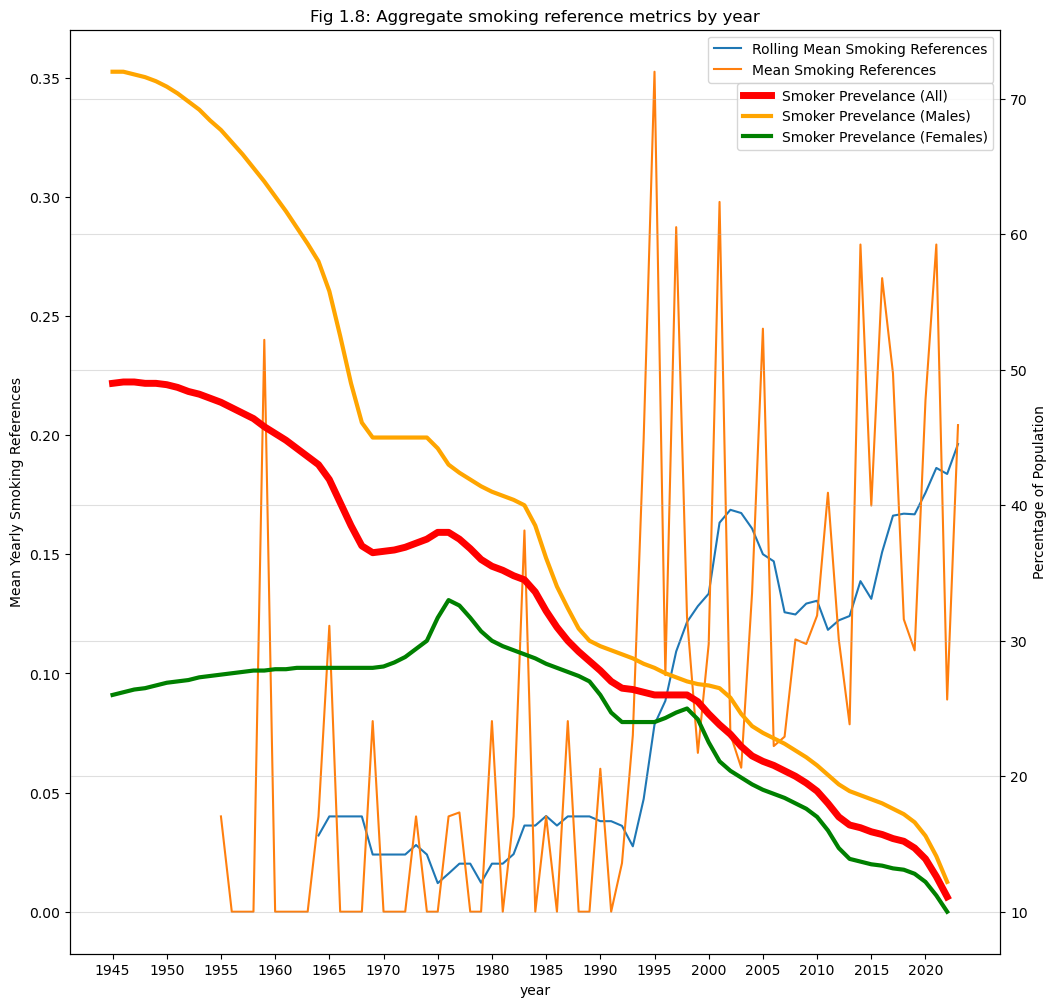

In [158]:
plt.figure(figsize=(12, 12))

sns.lineplot(yearly_lyric_data,y='rolling_mean_smoking_refs',x='year', linestyle = "-",label='Rolling Mean Smoking References')
sns.lineplot(yearly_lyric_data,y='mean_smoking_refs',x='year', linestyle = "-",label='Mean Smoking References')
#sns.lineplot(yearly_lyric_data,y='tfidf',x='year', linestyle = "-",label='Cumulative TFIDF')


plt.ylabel('Mean Yearly Smoking References')

ax2 = plt.twinx()

sns.lineplot(data,y='All',x='Year', label='Smoker Prevelance (All)',linewidth=5,ax=ax2,color='red')
sns.lineplot(data,y='Males',x='Year', label='Smoker Prevelance (Males)',linewidth=3,ax=ax2,color='Orange')
sns.lineplot(data,y='Females',x='Year', label='Smoker Prevelance (Females)',linewidth=3,ax=ax2,color='Green')
plt.xticks(range(1945, 2023, 5))

plt.grid(True,alpha=0.4)

plt.title('Fig 1.8: Aggregate smoking reference metrics by year')
plt.xlabel('Year')
plt.ylabel('Percentage of Population')

plt.legend(bbox_to_anchor = (1,.95))

plt.show()

# Machine Learning
To quantify the relationship between smoking references in music and actual smoking rates, we developed two regression models:

- Linear Regression: A straightforward model to establish a baseline
- Support Vector Regression (SVR): A more sophisticated model capable of capturing non-linear relationships

## Data Preparation
We first prepared our data by:

- Removing the year column (to avoid data leakage)
- Imputing any missing values
- Splitting into training (80%) and test (20%) sets
- Scaling features using StandardScaler

In [2]:
# prep variables
X = yearly_lyric_data[:-1].drop('year',axis=1) # remove year
X[pd.isna(X)] = 0 # impute missing values with 0
y = data[10:]['All'] # cull years with no music data

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

NameError: name 'yearly_lyric_data' is not defined

## Model Performance
### Linear Regression

In [122]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_scaled)

# Evaluate the model
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

print("Linear Regression Results:")
print(f"Mean Squared Error: {lr_mse}")
print(f"R-squared Score: {lr_r2}")

Linear Regression Results:
Mean Squared Error: 22.02060671743943
R-squared Score: 0.7979432665473127


Our linear regression model achieved a respectable R-squared score of 0.798, explaining nearly 80% of the variance in smoking prevalence. This suggests a strong linear relationship exists between our features and target variable.

### SVR

#### Hyperparameter Tuning

In [123]:
# Hyperparameter tuning for SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly'],
    'epsilon': [0.01, 0.1, 0.5]
}

In [124]:
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 0.5],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='neg_mean_squared_error')

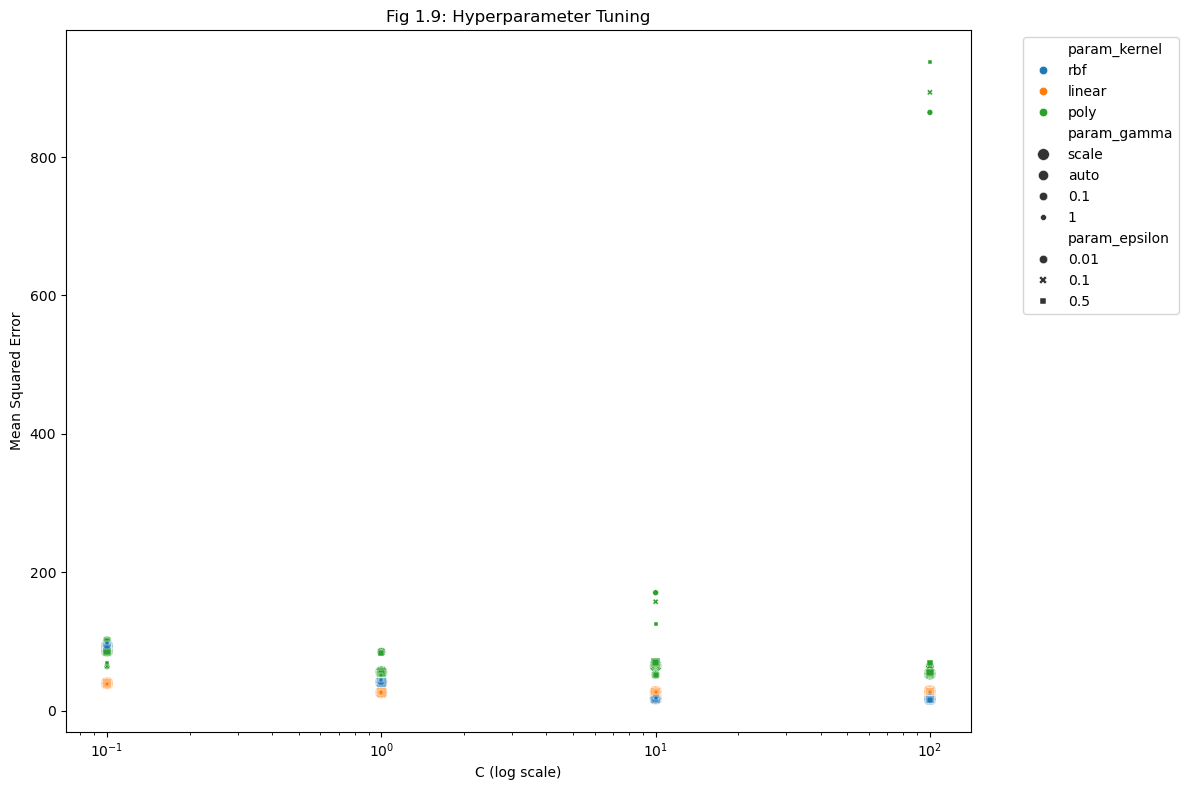

In [130]:
# Visualize hyperparameter tuning results
results = pd.DataFrame(grid_search.cv_results_)
results['mean_test_score'] = -results['mean_test_score']  # Convert back to MSE

plt.figure(figsize=(12, 8))
sns.scatterplot(data=results, x='param_C', y='mean_test_score', hue ='param_kernel', size='param_gamma', style='param_epsilon')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('Fig 1.9: Hyperparameter Tuning')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [141]:
# Print the best parameters
print("Best parameters for SVR:")
print(grid_search.best_params_)

Best parameters for SVR:
{'C': 100, 'epsilon': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}


### Tuned Model

In [140]:
# Use the best model for predictions
best_svr_model = grid_search.best_estimator_
svr_predictions = best_svr_model.predict(X_test_scaled)

# Evaluate the model
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)

print("Support Vector Regression Results (after tuning):")
print(f"Mean Squared Error: {svr_mse}")
print(f"R-squared Score: {svr_r2}")

Support Vector Regression Results (after tuning):
Mean Squared Error: 11.711293622879987
R-squared Score: 0.8925394852054478


The SVR model outperformes the linear regression model after hyperparameter tuning. Using GridSearchCV with 5-fold cross-validation, we found the optimal parameters (C=100, epsilon=0.5, gamma=0.1, kernel='rbf'). The tuned SVR model achieved an R-squared score of 0.893, explaining almost 90% of the variance.

## Results

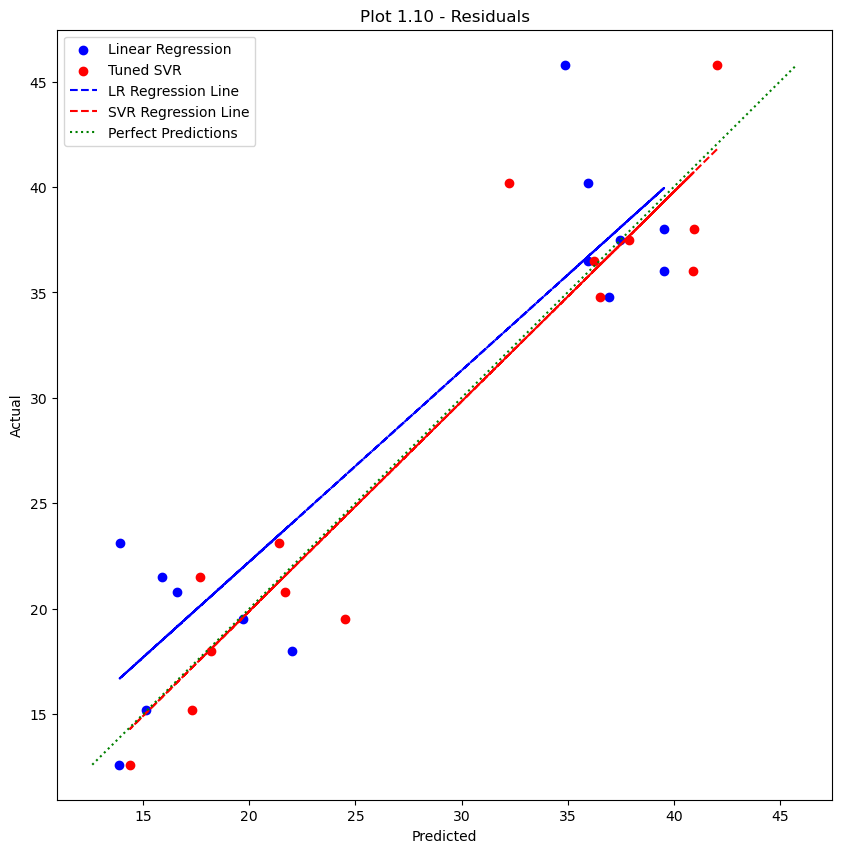

In [156]:
# Visualize the results
plt.figure(figsize=(10, 10))
#plt.scatter(X_test, y_test, color='black', label='Actual data')
plt.scatter(y=y_test, x=lr_predictions, color='blue', label='Linear Regression')
plt.scatter(y=y_test, x=svr_predictions, color='red', label='Tuned SVR')

# Add regression lines
lr_coef = np.polyfit(lr_predictions, y_test, 1)
lr_line = np.poly1d(lr_coef)
plt.plot(lr_predictions, lr_line(lr_predictions), color='blue', linestyle='--', label='LR Regression Line')

svr_coef = np.polyfit(svr_predictions, y_test, 1)
svr_line = np.poly1d(svr_coef)
plt.plot(svr_predictions, svr_line(svr_predictions), color='red', linestyle='--', label='SVR Regression Line')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Plot 1.10 - Residuals')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', linestyle=':', label='Perfect Predictions')

plt.legend()
plt.show()

This improvement indicates that the relationship between smoking references in music and smoking prevalence is indeed non-linear and complex.

## Conclusion and Limitations
Our analysis reveals a strong relationship between smoking references in popular music and smoking prevalence in Australia. The superior performance of the SVR model suggests this relationship is nuanced and non-linear.

However, it's important to acknowledge several limitations:
1. Correlation vs. Causation: Our models show correlation but cannot establish causation
2. Data Imbalance: We have fewer songs from earlier years, which could bias results
3. False Positives: Words like "smoke" and "drag" can appear in contexts unrelated to tobacco
4. Lyrics Accuracy: The accuracy of lyrics on Genius.com may vary, especially for older songs
5. Further investigation into the popularity of music genres could provide meaningufl nuance to the analysis.

Despite these limitations, our analysis provides compelling evidence that smoking references in popular music track with smoking prevalence in meaningful ways. This suggests that cultural factors reflected in music may indeed interact with public health trends - though the exact nature of this relationship requires further investigation.
Future work could explore additional features, incorporate time-series analysis techniques, or investigate potential causal relationships through more sophisticated modelling approaches.